<a href="https://colab.research.google.com/github/Aryanupadhyay23/Deep-Learning-/blob/main/VGG16_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
"""
import kagglehub
path = kagglehub.dataset_download("jtiptj/chest-xray-pneumoniacovid19tuberculosis")
"""

100%|██████████| 1.74G/1.74G [00:43<00:00, 42.6MB/s]

Extracting files...


In [7]:
path

'/root/.cache/kagglehub/datasets/jtiptj/chest-xray-pneumoniacovid19tuberculosis/versions/1'

In [8]:
import os
os.listdir(path)

['train', 'test', 'val']

In [9]:
os.listdir(f"{path}/train")

['NORMAL', 'PNEUMONIA', 'TURBERCULOSIS', 'COVID19']

In [12]:
"""
import shutil
import os

# Source: kagglehub cache location
src = "/root/.cache/kagglehub/datasets/jtiptj/chest-xray-pneumoniacovid19tuberculosis/versions/1"

# Destination: Colab working directory
dst = "/content/chest-xray-dataset"

# Remove destination if it already exists
if os.path.exists(dst):
    shutil.rmtree(dst)

# Copy dataset
shutil.copytree(src, dst)

print("Dataset copied to:", dst)
"""

Dataset copied to: /content/chest-xray-dataset


In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Rescaling

# For reproducibility
import numpy as np
import random
import os

seed = 123
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [16]:
# Directories containing the dataset
train_dir = "/content/chest-xray-dataset/train/"      # Update this path to your training data directory
val_dir = "/content/chest-xray-dataset/val/"          # Update this path to your validation data directory
test_dir = "/content/chest-xray-dataset/test/"        # Update this path to your testing data directory

# Hyperparameters
img_width, img_height = 224, 224
batch_size = 32
epochs = 20
num_classes = 4    # Update based on your dataset

In [17]:
# Load the datasets without validation split
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(img_width, img_height),
    batch_size=batch_size
)

Found 6326 files belonging to 4 classes.


In [18]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(img_width, img_height),
    batch_size=batch_size
)


Found 38 files belonging to 4 classes.


In [19]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(img_width, img_height),
    batch_size=batch_size
)

Found 771 files belonging to 4 classes.


In [20]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [21]:
# Apply data augmentation only to the training data
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

In [22]:
# Prefetch the datasets for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [23]:
def build_vgg16(input_shape=(224, 224, 3), num_classes=4):
    model = models.Sequential()

    # Add Input Layer
    model.add(layers.Input(shape=input_shape))

    # Normalization Layer
    model.add(Rescaling(1./255))

    # Block 1
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Fully Connected Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

In [25]:
model = build_vgg16(num_classes=num_classes)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │        16,38

 Total params: 134,276,932 (512.23 MB)

 Trainable params: 134,276,932 (512.23 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use 'categorical_crossentropy' if labels are one-hot encoded
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)

Epoch 1/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 227s 899ms/step - accuracy: 0.5769 - loss: 1.2163 - val_accuracy: 0.2105 - val_loss: 1.8185
Epoch 2/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 135s 680ms/step - accuracy: 0.6138 - loss: 1.0662 - val_accuracy: 0.2105 - val_loss: 1.7840
Epoch 3/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 129s 649ms/step - accuracy: 0.6143 - loss: 1.0598 - val_accuracy: 0.2105 - val_loss: 1.7316
Epoch 4/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 129s 652ms/step - accuracy: 0.6154 - loss: 1.0630 - val_accuracy: 0.2105 - val_loss: 1.7950
Epoch 5/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 129s 651ms/step - accuracy: 0.6158 - loss: 1.0606 - val_accuracy: 0.2105 - val_loss: 1.8166
Epoch 6/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 132s 663ms/step - accuracy: 0.6154 - loss: 1.0592 - val_accuracy: 0.2105 - val_loss: 1.8617
Epoch 7/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 129s 648ms/step - accuracy: 0.6185 - loss: 1.0556 - val_accuracy: 0.2105 - val_loss: 1.9146
Epoch 8/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 131s 658ms/step - accuracy: 0.6139 -

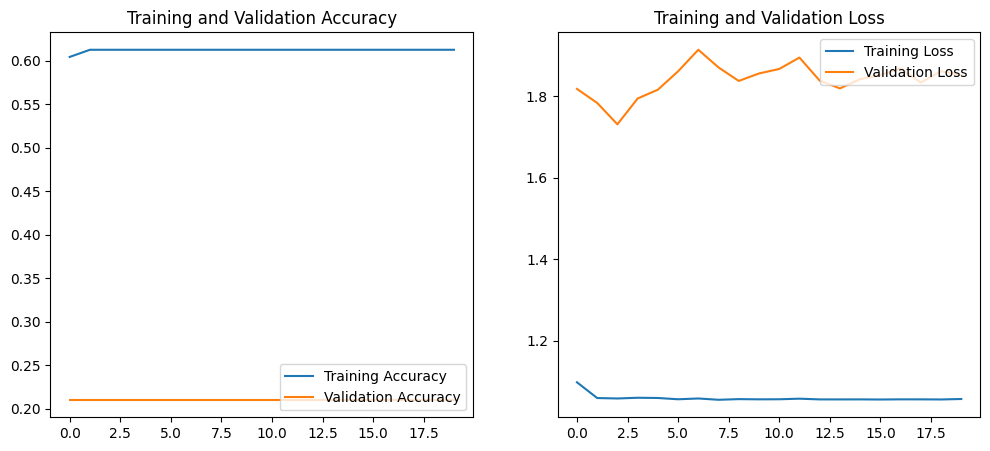

In [28]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [29]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 327ms/step - accuracy: 0.5274 - loss: 1.1830
Test Accuracy: 50.58%


In [30]:
# Train set predictions
y_train_true = np.concatenate([y for x, y in train_dataset], axis=0)
y_train_pred = model.predict(train_dataset)
y_train_pred = np.argmax(y_train_pred, axis=1)

# Validation set predictions
y_val_true = np.concatenate([y for x, y in validation_dataset], axis=0)
y_val_pred = model.predict(validation_dataset)
y_val_pred = np.argmax(y_val_pred, axis=1)

# Test set predictions
y_test_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_test_pred = model.predict(test_dataset)
y_test_pred = np.argmax(y_test_pred, axis=1)

198/198 ━━━━━━━━━━━━━━━━━━━━ 100s 500ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 497ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 290ms/step


In [31]:
from sklearn.metrics import confusion_matrix

# Confusion matrices
cm_train = confusion_matrix(y_train_true, y_train_pred)
cm_val = confusion_matrix(y_val_true, y_val_pred)
cm_test = confusion_matrix(y_test_true, y_test_pred)


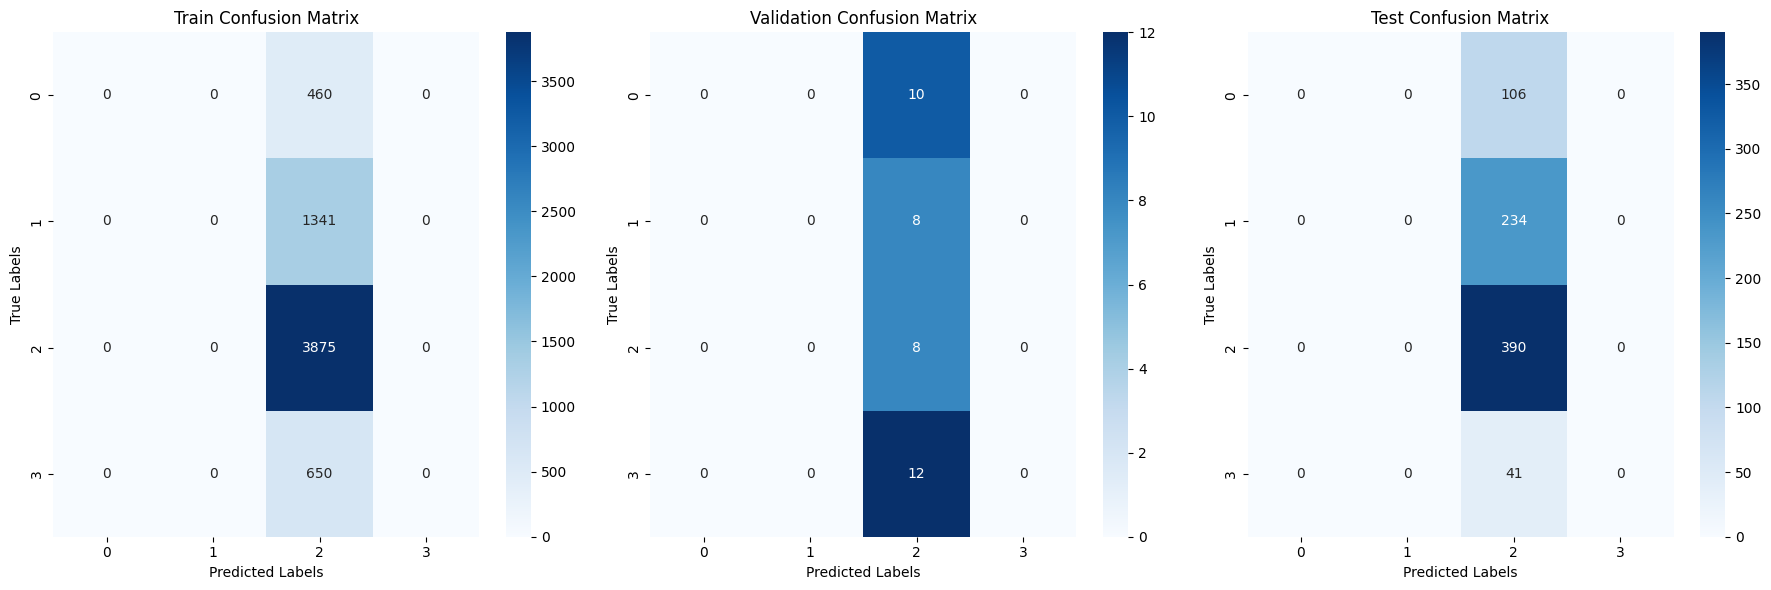

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Train Confusion Matrix
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Train Confusion Matrix')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

# Validation Confusion Matrix
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Validation Confusion Matrix')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

# Test Confusion Matrix
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_title('Test Confusion Matrix')
axes[2].set_xlabel('Predicted Labels')
axes[2].set_ylabel('True Labels')

# Adjust layout
plt.tight_layout()
plt.show()

## Transfer Learning

In [33]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Input

In [34]:
# Load VGG16 with pre-trained ImageNet weights, excluding the top (fully connected) layers
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_tensor=Input(shape=(img_width, img_height, 3))
)

base_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

In [36]:
# Build the model
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # Adjust the number of classes
])

In [37]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',  # or 'categorical_crossentropy' if labels are one-hot encoded
    metrics=['accuracy']
)

In [38]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10
)

Epoch 1/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 95s 456ms/step - accuracy: 0.7539 - loss: 4.1359 - val_accuracy: 0.8158 - val_loss: 1.4809
Epoch 2/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 134s 431ms/step - accuracy: 0.8941 - loss: 0.6427 - val_accuracy: 0.7632 - val_loss: 0.7795
Epoch 3/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 85s 429ms/step - accuracy: 0.9092 - loss: 0.3712 - val_accuracy: 0.8421 - val_loss: 0.5105
Epoch 4/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 85s 429ms/step - accuracy: 0.9327 - loss: 0.2620 - val_accuracy: 0.8947 - val_loss: 0.4183
Epoch 5/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 90s 452ms/step - accuracy: 0.9229 - loss: 0.2312 - val_accuracy: 0.8684 - val_loss: 0.5451
Epoch 6/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 90s 452ms/step - accuracy: 0.9329 - loss: 0.2267 - val_accuracy: 0.8421 - val_loss: 0.4152
Epoch 7/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 145s 468ms/step - accuracy: 0.9373 - loss: 0.1967 - val_accuracy: 0.9474 - val_loss: 0.3188
Epoch 8/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 137s 444ms/step - accuracy: 0.9386 - loss

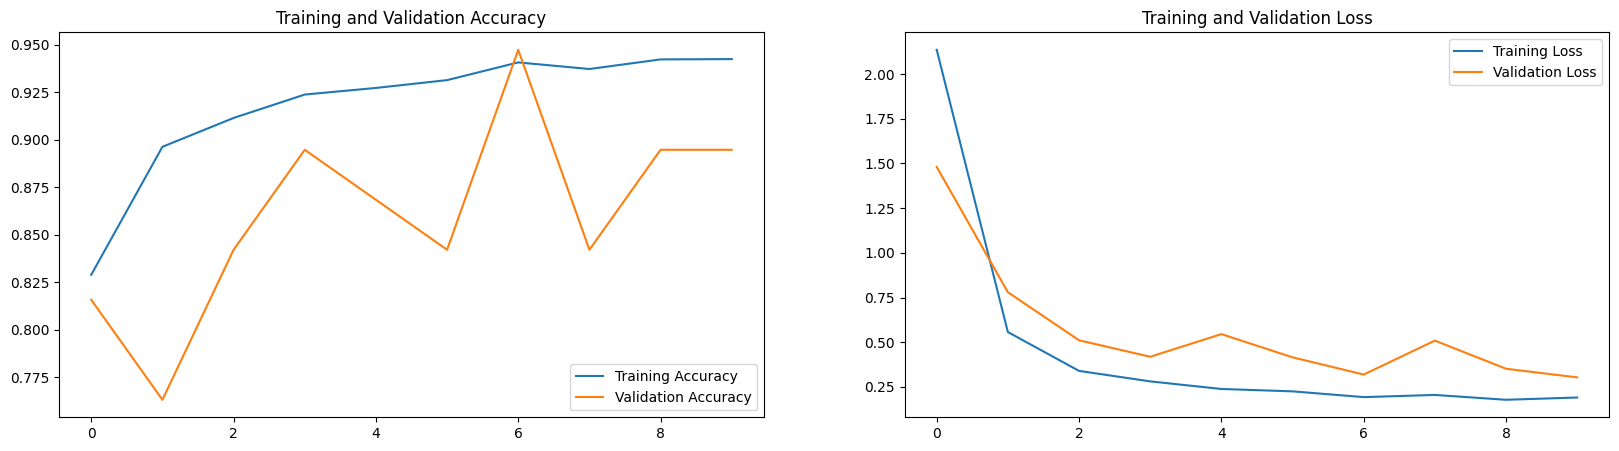

In [39]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [40]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - accuracy: 0.8341 - loss: 0.6501
Test Accuracy: 83.92%


In [41]:
# Train set predictions
y_train_true = np.concatenate([y for x, y in train_dataset], axis=0)
y_train_pred = model.predict(train_dataset)
y_train_pred = np.argmax(y_train_pred, axis=1)

# Validation set predictions
y_val_true = np.concatenate([y for x, y in validation_dataset], axis=0)
y_val_pred = model.predict(validation_dataset)
y_val_pred = np.argmax(y_val_pred, axis=1)

# Test set predictions
y_test_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_test_pred = model.predict(test_dataset)
y_test_pred = np.argmax(y_test_pred, axis=1)

198/198 ━━━━━━━━━━━━━━━━━━━━ 91s 454ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 296ms/step


In [42]:
from sklearn.metrics import confusion_matrix

# Confusion matrices
cm_train = confusion_matrix(y_train_true, y_train_pred)
cm_val = confusion_matrix(y_val_true, y_val_pred)
cm_test = confusion_matrix(y_test_true, y_test_pred)

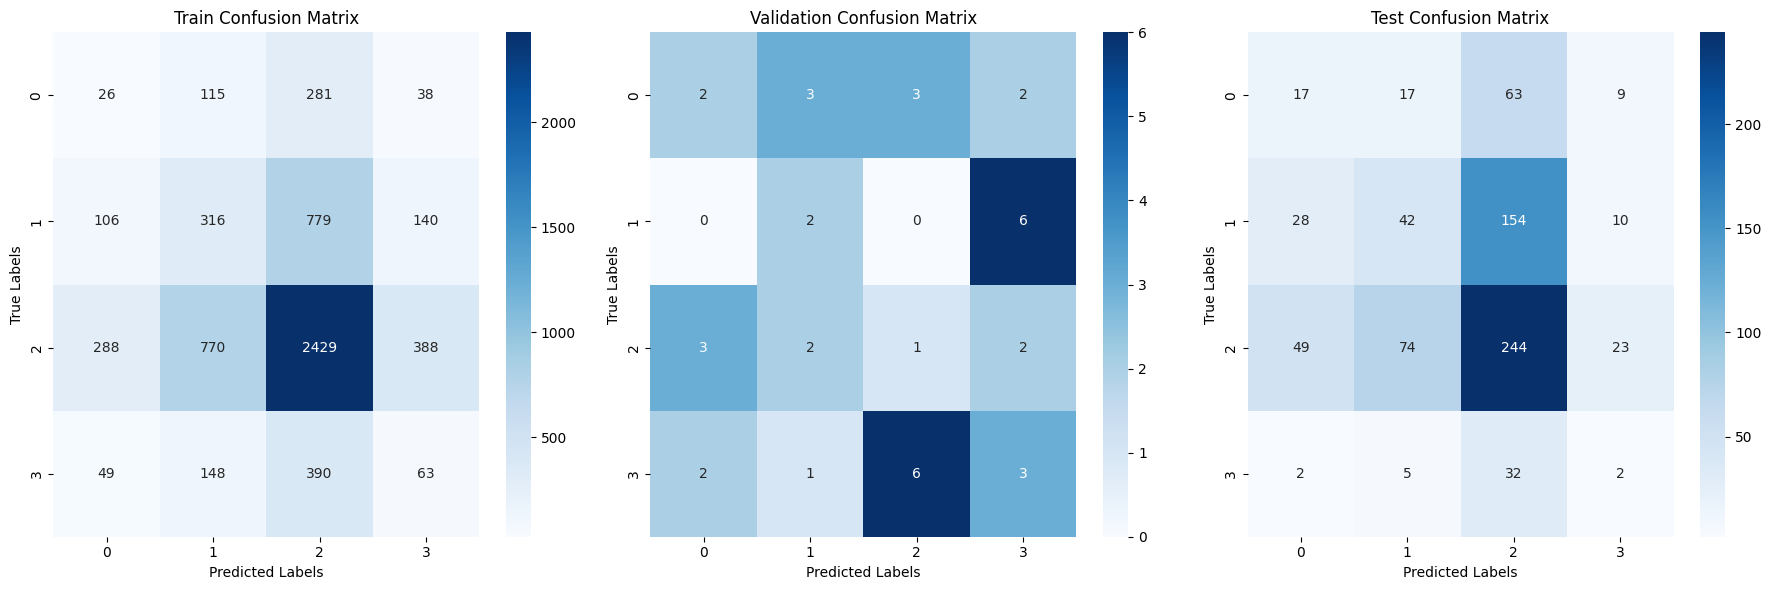

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Train Confusion Matrix
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Train Confusion Matrix')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

# Validation Confusion Matrix
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Validation Confusion Matrix')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

# Test Confusion Matrix
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_title('Test Confusion Matrix')
axes[2].set_xlabel('Predicted Labels')
axes[2].set_ylabel('True Labels')

# Adjust layout
plt.tight_layout()
plt.show()

In [44]:
# Load VGG16 with pre-trained ImageNet weights, excluding the top (fully connected) layers
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_tensor=Input(shape=(224, 224, 3))
)

# Freeze the first few layers
for layer in base_model.layers[:13]:   # Freeze first 13 layers, adjust as needed
    layer.trainable = False

# Unfreeze the remaining layers
for layer in base_model.layers[13:]:
    layer.trainable = True

In [45]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 9,439,232 (36.01 MB)

 Non-trainable params: 5,275,456 (20.12 MB)